# 📚 CLAHE Tutorial with NVIDIA DALI
Welcome to this hands-on tutorial!
In this notebook, you'll learn how to use Contrast Limited Adaptive Histogram Equalization (CLAHE) with NVIDIA DALI for image enhancement.

**Tutorial Roadmap:**
1. Introduction to CLAHE
2. Required Imports
3. Building a CLAHE Pipeline
4. Parameter Comparison
5. Running the Pipeline
6. Comparing DALI and OpenCV CLAHE
7. Visualizing Results
8. Practical Tips & Next Steps
9. Summary & Exercises

# 1️⃣ Introduction to CLAHE
This notebook demonstrates how to use **CLAHE (Contrast Limited Adaptive Histogram Equalization)** in a DALI pipeline for image preprocessing.

CLAHE is a powerful technique that improves contrast in images without overamplifying noise, making it particularly useful for medical imaging, surveillance, and low-contrast photography.

---


## 2️⃣ Required Imports
Let's start by importing the necessary DALI modules and NumPy for data analysis.

> **Try it yourself:** Run the cell below to import the libraries.

In [1]:
import nvidia.dali as dali
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import numpy as np

## 3️⃣ Building the CLAHE Pipeline
The main pipeline function creates a DALI processing pipeline that applies CLAHE enhancement to images. This pipeline can work with either real images from a directory or synthetic test data.

**Key CLAHE Parameters:**
- `tiles_x`, `tiles_y`: Grid size for local processing (higher = more local adaptation)
- `clip_limit`: Threshold to prevent noise amplification (higher = more contrast)
- `luma_only`: For RGB: process only luminance channel (preserves color balance)

> **Try it yourself:** Review the function below and see how you can adjust the parameters for your own images.

In [2]:
def create_clahe_pipeline(
    batch_size=4, num_threads=2, device_id=0, image_dir=None
):
    """
    Create a DALI pipeline with CLAHE operator.

    Args:
        batch_size (int): Number of images per batch
        num_threads (int): Number of worker threads
        device_id (int): GPU device ID
        image_dir (str): Directory containing images (if None, uses synthetic data)

    Returns:
        DALI pipeline with CLAHE preprocessing
    """

    @dali.pipeline_def(
        batch_size=batch_size, num_threads=num_threads, device_id=device_id
    )
    def clahe_preprocessing_pipeline():
        if image_dir:
            # Read images from directory
            images, labels = fn.readers.file(
                file_root=image_dir, random_shuffle=True
            )
            images = fn.decoders.image(images, device="mixed")  # Decode on GPU

            # Resize to consistent size
            images = fn.resize(images, size=[256, 256])
        else:
            # Create synthetic test images with varying contrast
            # This simulates real-world scenarios where CLAHE is beneficial

            # Generate base image with moderate values to avoid overflow
            images = fn.random.uniform(
                range=(60, 180), shape=(256, 256, 3), dtype=types.FLOAT
            )

            # Add some contrast variation to make CLAHE effect visible
            contrast_factor = fn.random.uniform(range=(0.5, 0.9))
            images = images * contrast_factor

            # Add small brightness variation (keeping within safe range)
            brightness_offset = fn.random.uniform(range=(-20, 20))
            images = images + brightness_offset

            # Convert to uint8 (DALI will automatically clamp to [0,255])
            images = fn.cast(images, dtype=types.UINT8)

        # 🎯 Apply CLAHE for adaptive histogram equalization
        # This is where the magic happens!
        clahe_images = fn.clahe(
            images,
            tiles_x=8,  # 8x8 grid of tiles for local processing
            tiles_y=8,
            clip_limit=2.0,  # Moderate clipping to prevent noise
            luma_only=True,  # RGB: process luminance only to preserve colors
        )

        return images, clahe_images

    return clahe_preprocessing_pipeline()

## 4️⃣ Parameter Comparison Function
Let's create a function to demonstrate how different CLAHE parameters affect the results.

> **Try it yourself:** Experiment with different values for `tiles_x`, `tiles_y`, and `clip_limit` to see their impact.

In [3]:
def demonstrate_clahe_parameters():
    """
    Demonstrate different CLAHE parameter settings to show their effects.

    Returns:
        DALI pipeline that generates one base image and three CLAHE variants
    """

    @dali.pipeline_def(batch_size=1, num_threads=1, device_id=0)
    def parameter_demo_pipeline():
        # Create a test image with poor contrast (narrow intensity range)
        base_image = fn.random.uniform(
            range=(80, 120), shape=(256, 256, 1), dtype=types.UINT8
        )

        # 🔧 Different CLAHE configurations to compare:

        # 1. Default settings - balanced approach
        clahe_default = fn.clahe(
            base_image,
            tiles_x=8,
            tiles_y=8,  # Standard 8x8 grid
            clip_limit=2.0,  # Moderate contrast limiting
        )

        # 2. Aggressive enhancement - more contrast, more local adaptation
        clahe_aggressive = fn.clahe(
            base_image,
            tiles_x=16,
            tiles_y=16,  # Finer 16x16 grid
            clip_limit=4.0,  # Higher contrast limit
        )

        # 3. Gentle enhancement - subtle improvement
        clahe_gentle = fn.clahe(
            base_image,
            tiles_x=4,
            tiles_y=4,  # Coarser 4x4 grid
            clip_limit=1.0,  # Conservative contrast limit
        )

        return base_image, clahe_default, clahe_aggressive, clahe_gentle

    return parameter_demo_pipeline()

## 5️⃣ Running the CLAHE Pipeline
Now let's execute our pipeline and see CLAHE in action! We'll analyze the results and measure the contrast improvement.

> **Try it yourself:** Run the next cell and observe the printed analysis for each image.

In [4]:
# 🏗️ Create and build pipeline
print("🔧 Creating CLAHE pipeline...")
pipe = create_clahe_pipeline(batch_size=2, num_threads=1, device_id=0)
pipe.build()
print("✅ Pipeline built successfully")

# 🎬 Run pipeline
print("\n🎬 Running pipeline...")
outputs = pipe.run()
original_images, clahe_images = outputs

# 📥 Move to CPU for analysis
original_batch = original_images.as_cpu()
clahe_batch = clahe_images.as_cpu()

print(f"✅ Processed {len(original_batch)} images")

# 📊 Analyze results
print("\n" + "=" * 50)
print("📊 CLAHE RESULTS ANALYSIS")
print("=" * 50)

for i in range(len(original_batch)):
    original = np.array(original_batch[i])
    enhanced = np.array(clahe_batch[i])

    print(f"\n🖼️  Image {i + 1}:")
    print(
        f"  📏 Original  - Shape: {original.shape}, Range: [{original.min():.1f}, {original.max():.1f}]"
    )
    print(
        f"  ✨ Enhanced  - Shape: {enhanced.shape}, Range: [{enhanced.min():.1f}, {enhanced.max():.1f}]"
    )

    # Calculate contrast metrics (standard deviation as a proxy for contrast)
    orig_std = np.std(original)
    enhanced_std = np.std(enhanced)
    contrast_improvement = enhanced_std / orig_std if orig_std > 0 else 1.0

    print(f"  📈 Contrast improvement: {contrast_improvement:.2f}x")

print("\n🎉 CLAHE pipeline executed successfully!")

🔧 Creating CLAHE pipeline...
✅ Pipeline built successfully

🎬 Running pipeline...
✅ Processed 2 images

📊 CLAHE RESULTS ANALYSIS

🖼️  Image 1:
  📏 Original  - Shape: (256, 256, 3), Range: [47.0, 135.0]
  ✨ Enhanced  - Shape: (256, 256, 3), Range: [14.0, 224.0]
  📈 Contrast improvement: 1.84x

🖼️  Image 2:
  📏 Original  - Shape: (256, 256, 3), Range: [43.0, 124.0]
  ✨ Enhanced  - Shape: (256, 256, 3), Range: [13.0, 208.0]
  📈 Contrast improvement: 1.84x

🎉 CLAHE pipeline executed successfully!
✅ Processed 2 images

📊 CLAHE RESULTS ANALYSIS

🖼️  Image 1:
  📏 Original  - Shape: (256, 256, 3), Range: [47.0, 135.0]
  ✨ Enhanced  - Shape: (256, 256, 3), Range: [14.0, 224.0]
  📈 Contrast improvement: 1.84x

🖼️  Image 2:
  📏 Original  - Shape: (256, 256, 3), Range: [43.0, 124.0]
  ✨ Enhanced  - Shape: (256, 256, 3), Range: [13.0, 208.0]
  📈 Contrast improvement: 1.84x

🎉 CLAHE pipeline executed successfully!


## 6️⃣ Parameter Comparison Experiment
Let's compare different CLAHE parameter settings to understand their effects on image enhancement.

> **Try it yourself:** Run the cell below and compare the standard deviation values for each configuration.

In [5]:
# 🔬 Demonstrate parameter variations
print("🔬 Testing different CLAHE parameters...")
param_pipe = demonstrate_clahe_parameters()
param_pipe.build()

param_outputs = param_pipe.run()
base, default, aggressive, gentle = param_outputs

# Convert to numpy arrays for analysis
base_img = np.array(base.as_cpu()[0])
default_img = np.array(default.as_cpu()[0])
aggressive_img = np.array(aggressive.as_cpu()[0])
gentle_img = np.array(gentle.as_cpu()[0])

# 📊 Compare the results
print("\n" + "=" * 60)
print("🎛️  PARAMETER COMPARISON RESULTS")
print("=" * 60)

configurations = [
    ("🔸 Base image (no CLAHE)", base_img),
    ("⚖️  Default CLAHE (8x8, limit=2.0)", default_img),
    ("🔥 Aggressive CLAHE (16x16, limit=4.0)", aggressive_img),
    ("🌸 Gentle CLAHE (4x4, limit=1.0)", gentle_img),
]

for name, img in configurations:
    std_dev = np.std(img)
    print(f"{name}")
    print(f"   📊 Standard deviation (contrast measure): {std_dev:.2f}")
    print()

print("💡 Key Takeaways:")
print("   • Higher std dev = more contrast")
print("   • More tiles (16x16) = more local adaptation")
print("   • Higher clip limit = stronger enhancement")
print("   • Choose parameters based on your image type and requirements!")

🔬 Testing different CLAHE parameters...

🎛️  PARAMETER COMPARISON RESULTS
🔸 Base image (no CLAHE)
   📊 Standard deviation (contrast measure): 11.57

⚖️  Default CLAHE (8x8, limit=2.0)
   📊 Standard deviation (contrast measure): 31.69

🔥 Aggressive CLAHE (16x16, limit=4.0)
   📊 Standard deviation (contrast measure): 49.64

🌸 Gentle CLAHE (4x4, limit=1.0)
   📊 Standard deviation (contrast measure): 21.29

💡 Key Takeaways:
   • Higher std dev = more contrast
   • More tiles (16x16) = more local adaptation
   • Higher clip limit = stronger enhancement
   • Choose parameters based on your image type and requirements!


## 7️⃣ Practical Applications & Next Steps
Where can you use CLAHE?
- 🏥 Medical Imaging: Enhance X-rays, CT scans, MRI images
- 👁️ Computer Vision: Improve object detection in low-contrast scenes
- 📸 Photography: Enhance details in shadows and highlights
- 🛡️ Security: Improve visibility in surveillance footage
- 🌌 Astronomy: Enhance celestial object visibility

**Parameter Tuning Guidelines:**
- Medical scans: tiles_x/y = 8-12, clip_limit = 1.5-2.5
- Natural photos: tiles_x/y = 6-10, clip_limit = 2.0-3.0
- Low-light images: tiles_x/y = 10-16, clip_limit = 3.0-4.0
- High-noise images: tiles_x/y = 4-8, clip_limit = 1.0-2.0

**Performance Tips:**
- Use `device="gpu"` for maximum performance
- Process images in batches when possible
- Set `luma_only=True` for RGB images to preserve color balance
- Experiment with parameters on representative samples

**Try These Experiments:**
1. Real Images: Replace synthetic data with your own image directory
2. Video Processing: Apply CLAHE to video frames in a sequence
3. Multi-scale Enhancement: Combine CLAHE with other DALI operators
4. Benchmarking: Compare CLAHE performance vs. other enhancement methods

## 8️⃣ DALI CLAHE vs OpenCV CLAHE Comparison
This section demonstrates a visual and quantitative comparison between DALI CLAHE (GPU/CPU) and OpenCV CLAHE using synthetic test images.

> **Try it yourself:** Run the next cells to see side-by-side results and difference maps.

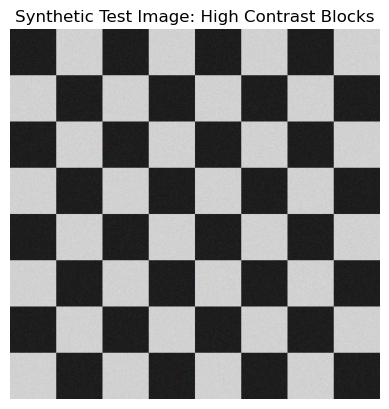

In [6]:
# --- Setup: Generate synthetic test image ---
import numpy as np
import cv2
import matplotlib.pyplot as plt


def create_synthetic_test_images():
    test_images = {}
    # High contrast checkerboard with poor local contrast
    img = np.zeros((512, 512, 3), dtype=np.uint8)
    block_size = 64
    for i in range(0, 512, block_size):
        for j in range(0, 512, block_size):
            if ((i // block_size) + (j // block_size)) % 2 == 0:
                img[i : i + block_size, j : j + block_size] = np.random.randint(
                    20, 40, (block_size, block_size, 3)
                )
            else:
                img[i : i + block_size, j : j + block_size] = np.random.randint(
                    200, 220, (block_size, block_size, 3)
                )
    test_images["high_contrast_blocks"] = img
    return test_images


test_images = create_synthetic_test_images()
image = test_images["high_contrast_blocks"]
plt.imshow(image)
plt.title("Synthetic Test Image: High Contrast Blocks")
plt.axis("off")
plt.show()

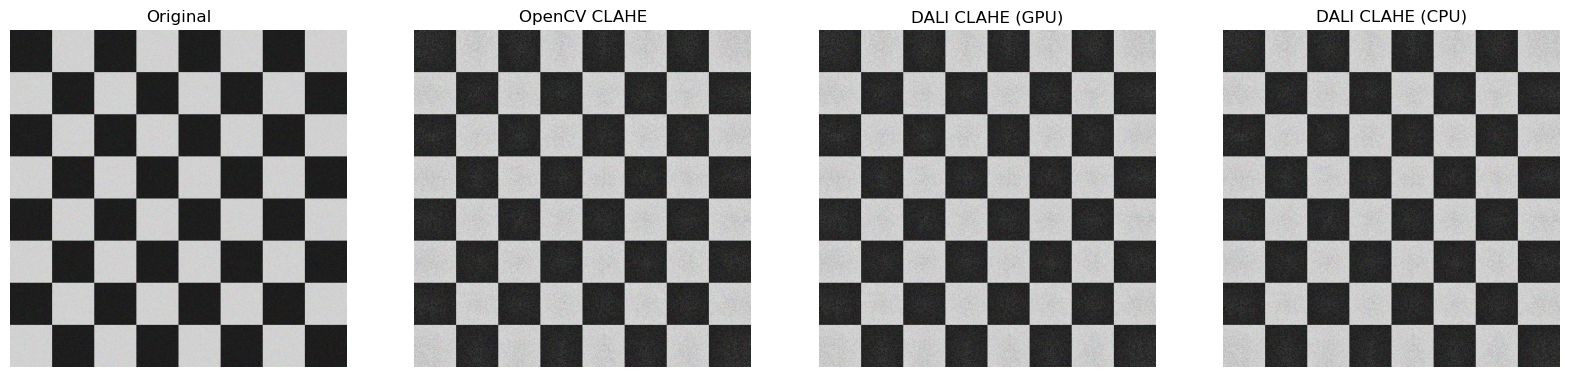

In [7]:
# --- CLAHE Processing: OpenCV and DALI ---
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline


def apply_opencv_clahe(
    image, tiles_x=8, tiles_y=8, clip_limit=2.0, luma_only=True
):
    clahe = cv2.createCLAHE(
        clipLimit=float(clip_limit), tileGridSize=(tiles_x, tiles_y)
    )
    if len(image.shape) == 3:
        if luma_only:
            lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
            lab[:, :, 0] = clahe.apply(lab[:, :, 0])
            result = cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)
        else:
            result = np.zeros_like(image)
            for i in range(3):
                result[:, :, i] = clahe.apply(image[:, :, i])
    else:
        result = clahe.apply(image)
    return result


class MemoryPipeline(Pipeline):
    def __init__(
        self, image_array, tiles_x=8, tiles_y=8, clip_limit=2.0, device="gpu"
    ):
        super().__init__(batch_size=1, num_threads=1, device_id=0)
        self.image_array = image_array
        self.tiles_x = tiles_x
        self.tiles_y = tiles_y
        self.clip_limit = clip_limit
        self.device = device

    def define_graph(self):
        images = fn.external_source(
            source=lambda: [self.image_array],
            device="cpu",
            dtype=types.DALIDataType.UINT8,
            ndim=3,
        )
        if self.device == "gpu":
            images_processed = images.gpu()
        else:
            images_processed = images
        clahe_result = fn.clahe(
            images_processed,
            tiles_x=self.tiles_x,
            tiles_y=self.tiles_y,
            clip_limit=float(self.clip_limit),
            luma_only=True,
            device=self.device,
        )
        return clahe_result


# Parameters
tiles_x, tiles_y, clip_limit = 8, 8, 2.0

# OpenCV CLAHE
opencv_result = apply_opencv_clahe(image, tiles_x, tiles_y, clip_limit)

# DALI CLAHE GPU
pipe_gpu = MemoryPipeline(image, tiles_x, tiles_y, clip_limit, "gpu")
pipe_gpu.build()
dali_gpu_result = pipe_gpu.run()[0].as_cpu().as_array()[0]

# DALI CLAHE CPU
pipe_cpu = MemoryPipeline(image, tiles_x, tiles_y, clip_limit, "cpu")
pipe_cpu.build()
dali_cpu_result = pipe_cpu.run()[0].as_cpu().as_array()[0]

# Show results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")
axes[1].imshow(opencv_result)
axes[1].set_title("OpenCV CLAHE")
axes[1].axis("off")
axes[2].imshow(dali_gpu_result)
axes[2].set_title("DALI CLAHE (GPU)")
axes[2].axis("off")
axes[3].imshow(dali_cpu_result)
axes[3].set_title("DALI CLAHE (CPU)")
axes[3].axis("off")
plt.show()

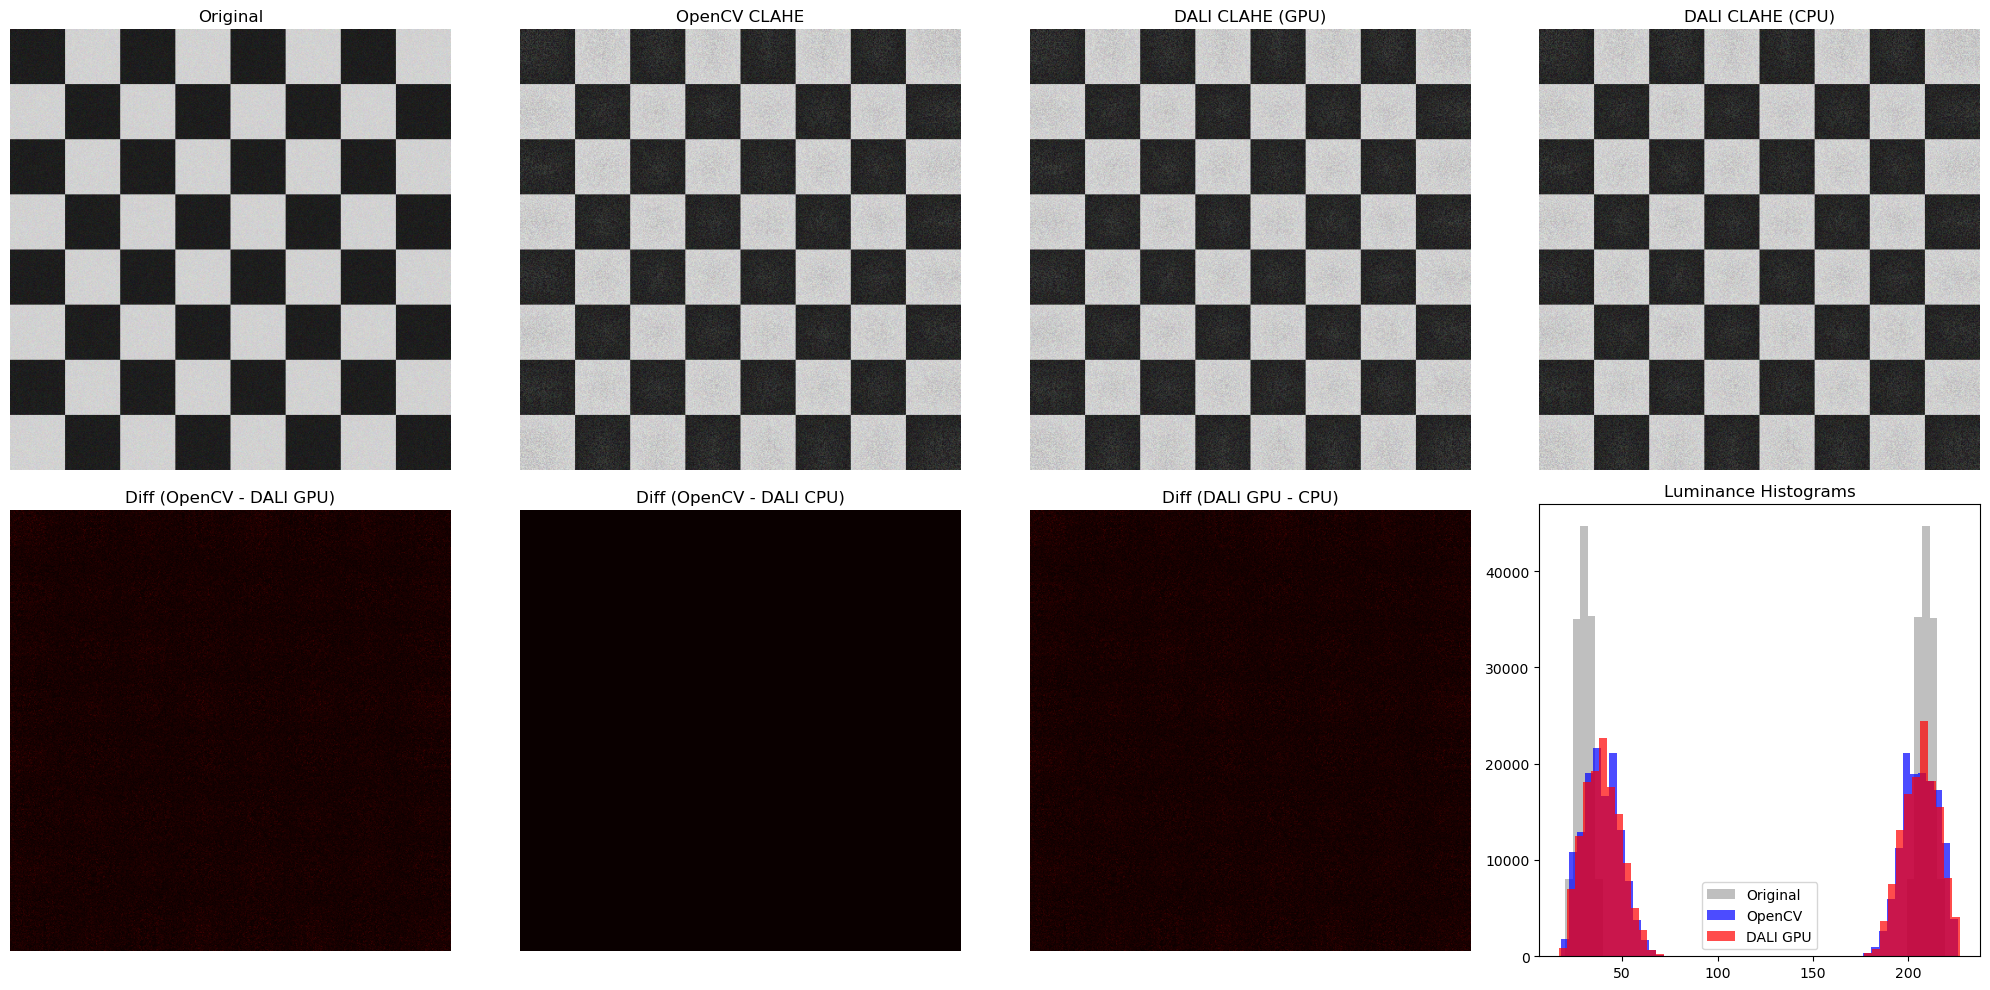

In [8]:
# --- Difference Maps and Luminance Histograms ---
def get_luminance(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:, :, 0]


diff_opencv_dali_gpu = np.abs(
    opencv_result.astype(float) - dali_gpu_result.astype(float)
)
diff_opencv_dali_cpu = np.abs(
    opencv_result.astype(float) - dali_cpu_result.astype(float)
)
diff_dali_gpu_cpu = np.abs(
    dali_gpu_result.astype(float) - dali_cpu_result.astype(float)
)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Top row: images
axes[0, 0].imshow(image)
axes[0, 0].set_title("Original")
axes[0, 0].axis("off")
axes[0, 1].imshow(opencv_result)
axes[0, 1].set_title("OpenCV CLAHE")
axes[0, 1].axis("off")
axes[0, 2].imshow(dali_gpu_result)
axes[0, 2].set_title("DALI CLAHE (GPU)")
axes[0, 2].axis("off")
axes[0, 3].imshow(dali_cpu_result)
axes[0, 3].set_title("DALI CLAHE (CPU)")
axes[0, 3].axis("off")

# Bottom row: difference maps
axes[1, 0].imshow(
    np.mean(diff_opencv_dali_gpu, axis=2), cmap="hot", vmin=0, vmax=50
)
axes[1, 0].set_title("Diff (OpenCV - DALI GPU)")
axes[1, 0].axis("off")
axes[1, 1].imshow(
    np.mean(diff_opencv_dali_cpu, axis=2), cmap="hot", vmin=0, vmax=50
)
axes[1, 1].set_title("Diff (OpenCV - DALI CPU)")
axes[1, 1].axis("off")
axes[1, 2].imshow(
    np.mean(diff_dali_gpu_cpu, axis=2), cmap="hot", vmin=0, vmax=50
)
axes[1, 2].set_title("Diff (DALI GPU - CPU)")
axes[1, 2].axis("off")

# Luminance histograms
orig_lum = get_luminance(image)
opencv_lum = get_luminance(opencv_result)
dali_gpu_lum = get_luminance(dali_gpu_result)

axes[1, 3].hist(
    orig_lum.ravel(), bins=50, alpha=0.5, color="gray", label="Original"
)
axes[1, 3].hist(
    opencv_lum.ravel(), bins=50, alpha=0.7, color="blue", label="OpenCV"
)
axes[1, 3].hist(
    dali_gpu_lum.ravel(), bins=50, alpha=0.7, color="red", label="DALI GPU"
)
axes[1, 3].set_title("Luminance Histograms")
axes[1, 3].legend()

plt.tight_layout()
plt.show()

## 9️⃣ Summary & Exercises
Congratulations! You've completed the CLAHE tutorial with NVIDIA DALI.

**Key Takeaways:**
- CLAHE enhances local contrast while limiting noise amplification.
- DALI provides fast, flexible, and GPU-accelerated CLAHE.
- Parameter tuning is essential for optimal results.

**Exercises:**
1. Try different images and parameter settings.
2. Integrate CLAHE into your own DALI pipelines.
3. Compare DALI CLAHE with other enhancement methods.

---
Feel free to experiment further and reach out with questions or feedback!